# Sampling of parameters for the uncertainty analysis

**Invert4Geom** uses a stochastic approach for quantifying uncertainties, which is described in detail in the [uncertainty analysis tutorial](../tutorial/10_uncertainty_analysis.ipynb). To perform this uncertainty analysis, we need to define a parameter space of the inversion inputs (data and/or parameters) to explore. This notebooks explains some of the theory behind sampling, and goes through the options we offer to do this.

Each sampling is used as the input to one inversion, so the number of total samples should be limited to reduce compute time. In these examples, we will use a limit of 10 samples, equating to 10 inversions.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

import invert4geom

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Random sampling

One method to define a parameter space and sample from it is to randomly sample values between some defined end members. Lets consider a simple case with parameters with expected values between 1 and 10. For a single parameter (1-dimension), we can randomly sample 10 values between these endpoints of 1 and 10. We can see with a limited numbers of samples, there are often large gaps left unexplored in the parameter space. 

To assess how large these gaps are, we can compute the distances to to the nearest sample.

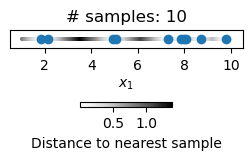

In [23]:
# randomly sample 10 points between 1 and 10
number_of_samples = 10
rng = np.random.default_rng(seed=42)
x1 = rng.random(number_of_samples)  # between 0 and 1
x1 = x1 * (10 - 1) + 1  # scale to between 1 and 10

# plot the samples along x1
fig, ax = plt.subplots(figsize=(3, 1))
plt.title(f"# samples: {number_of_samples}")
ax.scatter(x1, x1 * 0)
ax.set_xlim(0.5, 10.5)
ax.get_yaxis().set_visible(False)
_ = ax.set_xlabel("$x_1$")

# compute distance to nearest sample along x1 for a range of x1 values
x1_df = pd.DataFrame(x1, columns=["x1"])
x_vals_df = pd.DataFrame(np.linspace(1, 10, 1000), columns=["x1"])
min_distances = invert4geom.dist_nearest_points(x1_df, x_vals_df, coord_names="x1")

# plot the distance to nearest sample along x1
cb = ax.scatter(
    min_distances["x1"],
    min_distances["x1"] * 0,
    c=min_distances["min_dist"],
    s=2,
    cmap="Greys",
    zorder=-10,
)
plt.colorbar(
    cb,
    orientation="horizontal",
    label="Distance to nearest sample",
    fraction=0.06,
    pad=0.7,
)

We can look at a histogram of these distances to nearest sample values to determine how much of our parameter space is unexplored.

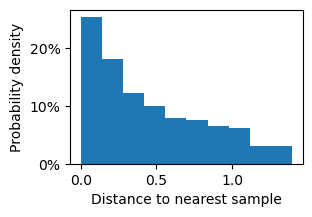

In [212]:
data = min_distances.min_dist
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

We can see that there are significant gaps in the parameter space which haven't been sampled. 

Moving to two parameters (2-dimensions), we can randomly sample the 2D parameter space 10 times.  

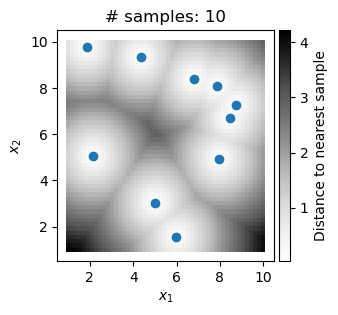

In [26]:
# sample 10 random points in 2D between 1 and 10
number_of_samples = 10
rng = np.random.default_rng(seed=42)
points = rng.random((number_of_samples, 2))  # between 0 and 1
points = points * (10 - 1) + 1  # scale to between 1 and
sample_df = pd.DataFrame(data={"x1": points[:, 0], "x2": points[:, 1]})

# plot the samples in 2D
fig, ax = plt.subplots(figsize=(3, 3))
plt.title(f"# samples: {number_of_samples}")
ax.scatter(sample_df.x1, sample_df.x2)
_ = ax.set_xlabel("$x_1$")
_ = ax.set_ylabel("$x_2$")
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.5, 10.5)

# compute distance to nearest sample in 2D for a grid of points
x1_grid = np.linspace(1, 10, 50)
x2_grid = np.linspace(1, 10, 50)
grid = xr.DataArray(
    data=np.ones((len(x1_grid), len(x2_grid))),
    dims=["x1", "x2"],
    coords={"x1": x1_grid, "x2": x2_grid},
)
min_distances = invert4geom.dist_nearest_points(
    sample_df, grid, coord_names=("x1", "x2")
)

# plot the distance to nearest sample in 2D
im = ax.pcolormesh(
    min_distances.x1,
    min_distances.x2,
    min_distances.values,
    cmap="Greys",
    zorder=-10,
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Distance to nearest sample")

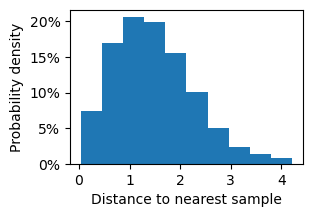

In [27]:
data = min_distances.values.flatten()
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

Now we can see with 2 parameters, now he have missed a much larger amount of the parameter space. To adequately cover the parameter space, we would need to increase to a large number of samples.

In 3D these gaps in the sampled parameter space grow even larger.

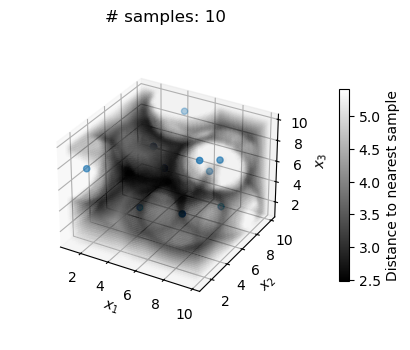

In [4]:
# sample 10 random points in 3D between 1 and 10
number_of_samples = 10
rng = np.random.default_rng(seed=42)
points = rng.random((number_of_samples, 3))  # between 0 and 1
points = points * (10 - 1) + 1  # scale to between 1 and
sample_df = pd.DataFrame(
    data={"x1": points[:, 0], "x2": points[:, 1], "x3": points[:, 2]}
)

# plot the samples in 3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
plt.title(f"# samples: {number_of_samples}")
ax.scatter(sample_df.x1, sample_df.x2, sample_df.x3)
_ = ax.set_xlabel("$x_1$")
_ = ax.set_ylabel("$x_2$")
_ = ax.set_zlabel("$x_3$")
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.5, 10.5)
ax.set_zlim(0.5, 10.5)

# compute distance to nearest sample in 3D for a grid of points
x1_grid = np.linspace(1, 10, 50)
x2_grid = np.linspace(1, 10, 50)
x3_grid = np.linspace(1, 10, 50)
grid = xr.DataArray(
    dims=["x1", "x2", "x3"], coords={"x1": x1_grid, "x2": x2_grid, "x3": x3_grid}
)
grid_df = grid.to_dataframe(name="data").reset_index().drop(columns="data")
min_distances = invert4geom.dist_nearest_points(
    sample_df, grid_df, coord_names=("x1", "x2", "x3")
)

# plot the distance to nearest sample in 3D
df = min_distances[min_distances.min_dist > min_distances.min_dist.mean()]
im = ax.scatter(
    df.x1,
    df.x2,
    df.x3,
    c=df.min_dist,
    cmap="gray",
    alpha=0.01,
    edgecolors="none",
)
cbar = fig.colorbar(im, ax=ax, label="Distance to nearest sample", shrink=0.5)
_ = cbar.solids.set(alpha=1)

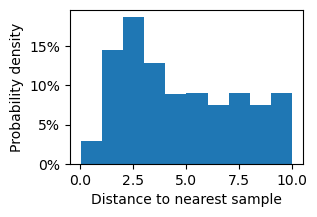

In [5]:
data = min_distances.values.flatten()
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

## Grid search
A typical approach used for defining a parameter space is to regularly sample values between parameter end values. Lets consider a simple case with parameters with expected values between 1 and 10. For a single parameter (1-dimension), we can use 10 values evenly spaced between these endpoints of 1 and 10.

(0.5, 10.5)

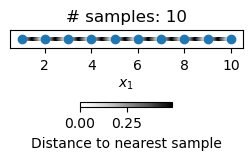

In [379]:
# uniformly sample 10 points in 2D between 1 and 10
number_of_samples = 10
x1 = np.linspace(1, 10, number_of_samples)

# plot the samples along x1
fig, ax = plt.subplots(figsize=(3, 1))
plt.title(f"# samples: {number_of_samples}")
ax.scatter(x1, x1 * 0)
ax.get_yaxis().set_visible(False)
_ = ax.set_xlabel("$x_1$")

# compute distance to nearest sample along x1 for a range of x1 values
x1_df = pd.DataFrame(x1, columns=["x1"])
x_vals_df = pd.DataFrame(np.linspace(1, 10, 1000), columns=["x1"])
min_distances = invert4geom.dist_nearest_points(x1_df, x_vals_df, coord_names="x1")

# plot the distance to nearest sample along x1
cb = ax.scatter(
    min_distances["x1"],
    min_distances["x1"] * 0,
    c=min_distances["min_dist"],
    s=2,
    cmap="Greys",
    zorder=-10,
)
plt.colorbar(
    cb,
    orientation="horizontal",
    label="Distance to nearest sample",
    fraction=0.06,
    pad=0.7,
)
ax.set_xlim(0.5, 10.5)

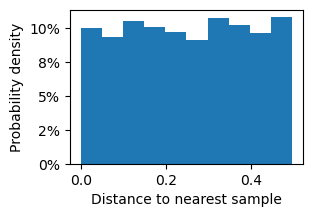

In [380]:
data = min_distances.min_dist
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

If we have two parameters (2-dimensions), we can sample 9 evenly spaced sets of parameter values.

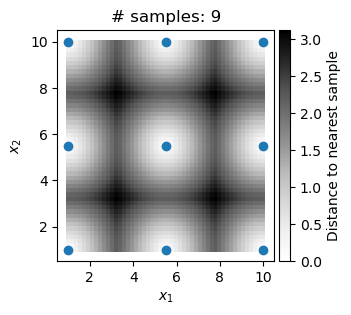

In [ ]:
# uniformly sample ~10 points in 2D between 1 and 10
number_of_samples = 10
x1 = np.linspace(1, 10, round(number_of_samples ** (1 / 2)))
x2 = np.linspace(1, 10, round(number_of_samples ** (1 / 2)))
xx, yy = np.meshgrid(x1, x2)
sample_df = pd.DataFrame(data={"x1": xx.ravel(), "x2": yy.ravel()})

# plot the samples in 2D
fig, ax = plt.subplots(figsize=(3, 3))
plt.title(f"# samples: {len(sample_df)}")
ax.scatter(sample_df.x1, sample_df.x2)
_ = ax.set_xlabel("$x_1$")
_ = ax.set_ylabel("$x_2$")
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.5, 10.5)

# compute distance to nearest sample in 2D for a grid of points
x1_grid = np.linspace(1, 10, 50)
x2_grid = np.linspace(1, 10, 50)
grid = xr.DataArray(
    data=np.ones((len(x1_grid), len(x2_grid))),
    dims=["x1", "x2"],
    coords={"x1": x1_grid, "x2": x2_grid},
)
min_distances = invert4geom.dist_nearest_points(
    sample_df, grid, coord_names=("x1", "x2")
)

# plot the distance to nearest sample in 2D
im = ax.pcolormesh(
    min_distances.x1,
    min_distances.x2,
    min_distances.values,
    cmap="Greys",
    zorder=-10,
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Distance to nearest sample")

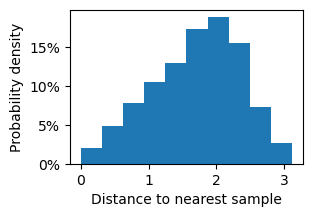

In [7]:
data = min_distances.values.flatten()
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

Extending this to three parameters (3-dimensions) we can sample 8 evenly spaced values, leading to even larger gaps in the parameter space. 

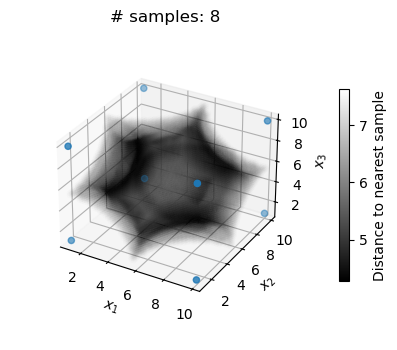

In [8]:
# uniformly sample ~10 points in 3D between 1 and 10
number_of_samples = 10
x1 = np.linspace(1, 10, round(number_of_samples ** (1 / 3)))
x2 = np.linspace(1, 10, round(number_of_samples ** (1 / 3)))
x3 = np.linspace(1, 10, round(number_of_samples ** (1 / 3)))
grid = xr.DataArray(dims=["x1", "x2", "x3"], coords={"x1": x1, "x2": x2, "x3": x3})
sample_df = grid.to_dataframe(name="data").reset_index().drop(columns="data")

# plot the samples in 3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")
plt.title(f"# samples: {len(sample_df)}")
ax.scatter(sample_df.x1, sample_df.x2, sample_df.x3)
_ = ax.set_xlabel("$x_1$")
_ = ax.set_ylabel("$x_2$")
_ = ax.set_zlabel("$x_3$")
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.5, 10.5)
ax.set_zlim(0.5, 10.5)

# compute distance to nearest sample in 3D for a grid of points
x1_grid = np.linspace(1, 10, 50)
x2_grid = np.linspace(1, 10, 50)
x3_grid = np.linspace(1, 10, 50)
grid = xr.DataArray(
    dims=["x1", "x2", "x3"], coords={"x1": x1_grid, "x2": x2_grid, "x3": x3_grid}
)
grid_df = grid.to_dataframe(name="data").reset_index().drop(columns="data")
min_distances = invert4geom.dist_nearest_points(
    sample_df, grid_df, coord_names=("x1", "x2", "x3")
)

# plot the distance to nearest sample in 3D
df = min_distances[min_distances.min_dist > min_distances.min_dist.mean()]
im = ax.scatter(
    df.x1,
    df.x2,
    df.x3,
    c=df.min_dist,
    cmap="gray",
    alpha=0.01,
    edgecolors="none",
)
cbar = fig.colorbar(im, ax=ax, label="Distance to nearest sample", shrink=0.5)
_ = cbar.solids.set(alpha=1)

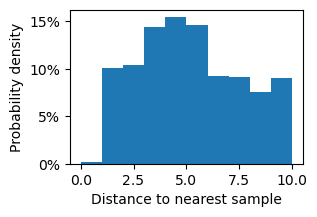

In [9]:
data = min_distances.values.flatten()
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

While a grid search can evenly cover the parameter space, we can see to adequately cover high-dimension parameter spaces would require many samples, and therefor many inversions.

An alternative is to use **Latin Hypercube Sampling**. This is implemented in **Invert4Geom** with the function `create_lhc`.

## Latin Hypercube Sampling

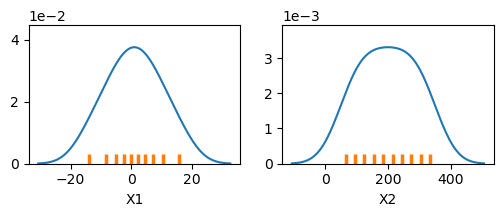

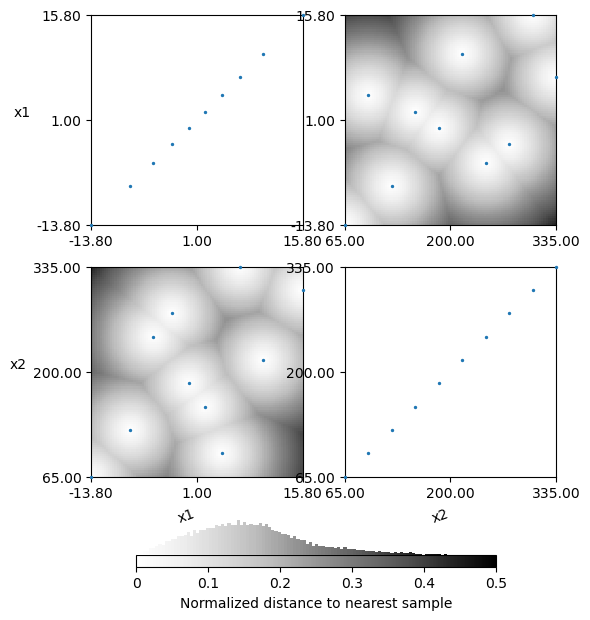

{'x1': {'distribution': 'normal',
  'loc': 1,
  'scale': 9,
  'sampled_values': array([ -5.07040775,  -0.13095212,  -2.4678842 , -13.80368264,
           4.4678842 ,  -8.32790051,   2.13095212,  10.32790051,
           7.07040775,  15.80368264])},
 'x2': {'distribution': 'uniform_discrete',
  'loc': 50,
  'scale': 300,
  'sampled_values': array([245., 185., 275.,  65.,  95., 125., 155., 215., 335., 305.])}}

In [43]:
lhc = invert4geom.create_lhc(
    n_samples=10,
    parameter_dict={
        "x1": {"distribution": "normal", "loc": 1, "scale": 9},
        "x2": {"distribution": "uniform_discrete", "loc": 50, "scale": 300},
    },
    criterion="centered",
)
invert4geom.plot_latin_hypercube(lhc)
lhc

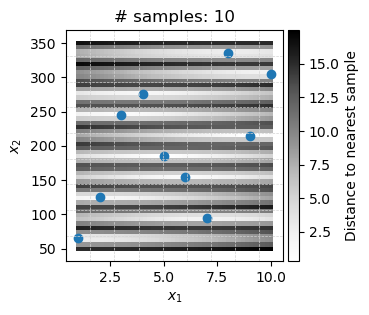

In [32]:
sample_df = pd.DataFrame(
    data={"x1": lhc["x1"]["sampled_values"], "x2": lhc["x2"]["sampled_values"]}
)

# get LHC bins for each parameter
x1_bin_width = x1_bins[1] - x1_bins[0]
x2_bin_width = x2_bins[1] - x2_bins[0]
x1_bins = np.linspace(
    lhc["x1"]["loc"] - x1_bin_width / 2,
    lhc["x1"]["loc"] + lhc["x1"]["scale"] + x1_bin_width / 2,
    10,
)
x2_bins = np.linspace(
    lhc["x2"]["loc"] - x2_bin_width / 2,
    lhc["x2"]["loc"] + lhc["x2"]["scale"] + x2_bin_width / 2,
    10,
)

# plot the samples in 2D
fig, ax = plt.subplots(figsize=(3, 3))
plt.title(f"# samples: {len(sample_df)}")
ax.scatter(sample_df.x1, sample_df.x2)
_ = ax.set_xlabel("$x_1$")
_ = ax.set_ylabel("$x_2$")
ax.set_xlim(x1_bins[0], x1_bins[-1])
ax.set_ylim(x2_bins[0], x2_bins[-1])

# compute distance to nearest sample in 2D for a grid of points
x1_grid = np.linspace(lhc["x1"]["loc"], lhc["x1"]["loc"] + lhc["x1"]["scale"], 50)
x2_grid = np.linspace(lhc["x2"]["loc"], lhc["x2"]["loc"] + lhc["x2"]["scale"], 50)
grid = xr.DataArray(
    data=np.ones((len(x1_grid), len(x2_grid))),
    dims=["x1", "x2"],
    coords={"x1": x1_grid, "x2": x2_grid},
)
min_distances = invert4geom.dist_nearest_points(
    sample_df, grid, coord_names=("x1", "x2")
)
# min_distances =  invert4geom.normalize_xarray(min_distances, low=0, high=1)

# plot the distance to nearest sample in 2D
im = ax.pcolormesh(
    min_distances.x1,
    min_distances.x2,
    min_distances.values,
    cmap="Greys",
    zorder=-10,
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Distance to nearest sample")

for x in x1_bins:
    ax.axvline(x, color="lightgray", linestyle="--", linewidth=0.5)
for y in x2_bins:
    ax.axhline(y, color="lightgray", linestyle="--", linewidth=0.5)

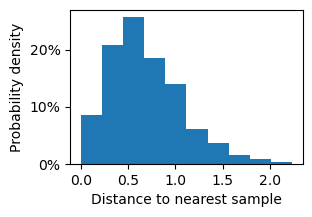

In [335]:
data = min_distances.values.flatten()
fig, ax = plt.subplots(figsize=(3, 2))
_ = plt.hist(data, weights=np.ones(len(data)) / len(data), bins=10)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
_ = plt.xlabel("Distance to nearest sample")
_ = plt.ylabel("Probability density")

## Distribution types

### Uniform

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=15,
    parameter_dict={
        "param1": {"distribution": "uniform", "loc": 0, "scale": 10},
    },
)
invert4geom.plot_latin_hypercube(lhc)
lhc

### Log uniform

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=15,
    parameter_dict={
        "param1_log": {"distribution": "uniform", "loc": 0, "scale": 10, "log": True},
    },
)
invert4geom.plot_latin_hypercube(lhc)
lhc

### Uniform discrete

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=15,
    parameter_dict={
        "param2": {"distribution": "uniform_discrete", "loc": 0, "scale": 10},
    },
)
invert4geom.plot_latin_hypercube(lhc)
lhc

### Normal

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=15,
    parameter_dict={
        "param3": {"distribution": "normal", "loc": 0, "scale": 10},
    },
)
invert4geom.plot_latin_hypercube(lhc)
lhc

### Log normal

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=15,
    parameter_dict={
        "param3_log": {"distribution": "normal", "loc": 0, "scale": 10, "log": True},
    },
)
invert4geom.plot_latin_hypercube(lhc)
lhc

## Sampling criterion: 1D
* centered: samples centered in the bins of equal probability  
* random: completely random sampling in each bin of equal probability

In [ ]:
criterions = ["centered", "random"]

for c in criterions:
    lhc = invert4geom.create_lhc(
        n_samples=6,
        parameter_dict={
            "param1": {"distribution": "uniform", "loc": 0, "scale": 10},
        },
        criterion=c,
    )
    print(f"Criterion: {c}")
    invert4geom.plot_latin_hypercube(lhc)

## 2D sampling

## Sampling criterion: 2D
* centered: samples centered in the bins of equal probability  
* random: completely random sampling in each bin of equal probability
* maximin: aims to maximize the minimum distance between samples
* mincorrelation: aims to minimize spurious correlations

In [ ]:
lhc = invert4geom.create_lhc(
    n_samples=10,
    parameter_dict={
        "param1": {"distribution": "uniform", "loc": 0, "scale": 10},
        "param2": {"distribution": "uniform", "loc": 0, "scale": 10},
    },
)
lhc

In [ ]:
import pandas as pd

df = pd.DataFrame(
    [lhc[x]["sampled_values"] for x in lhc],
).transpose()
df

In [ ]:
sample = df.values
sample

In [ ]:
z_mk, pval_mk = invert4geom.uncertainty.mann_kendall_test_sample(sample)
z_mk, pval_mk

In [ ]:
[z_mk, pval_mk] = invert4geom.uncertainty.mann_kendall_test_sample(sample)
[rho, pval_pr] = invert4geom.uncertainty.pearson_test_sample(sample)

invert4geom.plotting.correlation_plots(z_mk, pval_mk, df.columns)
invert4geom.plotting.correlation_plots(rho, pval_pr, df.columns)

In [ ]:
criterions = ["centered", "random", "maximin", "mincorrelation"]

for c in criterions:
    lhc = invert4geom.create_lhc(
        n_samples=10,
        parameter_dict={
            "param1": {"distribution": "uniform", "loc": 0, "scale": 10},
            "param2": {"distribution": "uniform", "loc": 0, "scale": 10},
            "param3": {"distribution": "normal", "loc": 0, "scale": 10},
        },
        criterion=c,
    )
    print(f"Criterion: {c}")
    invert4geom.plot_latin_hypercube(
        lhc,
    )